In [1]:
import os
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
filename = '/Users/a1/Desktop/project/pytorch_practice/data/N-CMAPSS_DS02-006.h5'

In [3]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.007124433333333332

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [4]:
print("dev_engines:", np.unique(A_dev[:, 0]))
print("test_engines:",np.unique(A_test[:, 0]))

dev_engines: [ 2.  5. 10. 16. 18. 20.]
test_engines: [11. 14. 15.]


In [5]:
# 입력
eng = A_dev[:, 0].astype(int)
state = A_dev[:, 3].astype(int)

normal_ranges = []
abnormal_ranges = []

start = 0

for i in range(1, len(state)):
    # 구간 종료 조건:
    # 1) state 변화
    # 2) 엔진 변화
    if (state[i] != state[i - 1]) or (eng[i] != eng[i - 1]):
        end = i - 1
        if state[start] == 1:
            normal_ranges.append((start, end))
        else:
            abnormal_ranges.append((start, end))
        start = i

# 마지막 구간 처리
end = len(state) - 1
if state[start] == 1:
    normal_ranges.append((start, end))
else:
    abnormal_ranges.append((start, end))

print("\n=== Range summary (A_dev index) ===")
print(f"Total normal ranges   : {len(normal_ranges)}")
print(f"Total abnormal ranges : {len(abnormal_ranges)}")

print("\nNormal ranges by engine:")
for (s, e) in normal_ranges:
    print(f"  Engine {eng[s]} : [{s}, {e}] (len={e - s + 1})")

print("\nAbnormal ranges by engine:")
for (s, e) in abnormal_ranges:
    print(f"  Engine {eng[s]} : [{s}, {e}] (len={e - s + 1})")


normal_engines   = [2, 5, 10]
abnormal_engines = [2, 5, 10]

K = 300  # 엔진별, 구간별 샘플 수

sampled_dev_idx_list = []

for eng_id in normal_engines:
    for (s, e) in normal_ranges:
        if eng[s] != eng_id:
            continue

        idx = np.arange(s, e + 1)
        T = len(idx)
        if T <= 0:
            continue

        k = min(K, T)
        pos = np.linspace(0, T - 1, num=k)
        pos = np.round(pos).astype(int)
        pos = np.unique(pos)

        if pos.size < k:
            pool = np.setdiff1d(np.arange(T), pos)
            need = k - pos.size
            add = np.round(np.linspace(0, pool.size - 1, num=need)).astype(int)
            pos = np.sort(np.concatenate([pos, pool[add]]))
        else:
            pos = np.sort(pos[:k])

        sampled_dev_idx_list.append(idx[pos])

sampled_dev_idx = np.sort(np.unique(np.concatenate(sampled_dev_idx_list)))

print("\n=== DEV sampling (normal state) ===")
print(f"Target engines : {normal_engines}")
print(f"Samples per range (K) : {K}")

dev_count_by_engine = {e: 0 for e in normal_engines}

for eng_id in normal_engines:
    for (s, e) in normal_ranges:
        if eng[s] != eng_id:
            continue

        T = e - s + 1
        k_used = min(K, T)
        dev_count_by_engine[eng_id] += k_used

        print(
            f"  Engine {eng_id} | range [{s},{e}] "
            f"| range_len={T} | sampled={k_used}"
        )

print("\nDEV sampled count by engine:")
for eng_id, cnt in dev_count_by_engine.items():
    print(f"  Engine {eng_id} : {cnt}")

print(f"\nTotal DEV sampled indices: {len(sampled_dev_idx)}")


sampled_test_idx_list = []

for eng_id in abnormal_engines:
    for (s, e) in abnormal_ranges:
        if eng[s] != eng_id:
            continue

        idx = np.arange(s, e + 1)
        T = len(idx)
        if T <= 0:
            continue

        k = min(K, T)
        pos = np.linspace(0, T - 1, num=k)
        pos = np.round(pos).astype(int)
        pos = np.unique(pos)

        if pos.size < k:
            pool = np.setdiff1d(np.arange(T), pos)
            need = k - pos.size
            add = np.round(np.linspace(0, pool.size - 1, num=need)).astype(int)
            pos = np.sort(np.concatenate([pos, pool[add]]))
        else:
            pos = np.sort(pos[:k])

        sampled_test_idx_list.append(idx[pos])

sampled_test_idx = np.sort(np.unique(np.concatenate(sampled_test_idx_list)))

print("\n=== TEST sampling (abnormal state) ===")
print(f"Target engines : {abnormal_engines}")
print(f"Samples per range (K) : {K}")

test_count_by_engine = {e: 0 for e in abnormal_engines}

for eng_id in abnormal_engines:
    for (s, e) in abnormal_ranges:
        if eng[s] != eng_id:
            continue

        T = e - s + 1
        k_used = min(K, T)
        test_count_by_engine[eng_id] += k_used

        print(
            f"  Engine {eng_id} | range [{s},{e}] "
            f"| range_len={T} | sampled={k_used}"
        )

print("\nTEST sampled count by engine:")
for eng_id, cnt in test_count_by_engine.items():
    print(f"  Engine {eng_id} : {cnt}")

print(f"\nTotal TEST sampled indices: {len(sampled_test_idx)}")



=== Range summary (A_dev index) ===
Total normal ranges   : 6
Total abnormal ranges : 6

Normal ranges by engine:
  Engine 2 : [0, 188862] (len=188863)
  Engine 5 : [853142, 1041691] (len=188550)
  Engine 10 : [1886562, 2074611] (len=188050)
  Engine 16 : [2839273, 3033891] (len=194619)
  Engine 18 : [3604568, 3797856] (len=193289)
  Engine 20 : [4495287, 4688640] (len=193354)

Abnormal ranges by engine:
  Engine 2 : [188863, 853141] (len=664279)
  Engine 5 : [1041692, 1886561] (len=844870)
  Engine 10 : [2074612, 2839272] (len=764661)
  Engine 16 : [3033892, 3604567] (len=570676)
  Engine 18 : [3797857, 4495286] (len=697430)
  Engine 20 : [4688641, 5263446] (len=574806)

=== DEV sampling (normal state) ===
Target engines : [2, 5, 10]
Samples per range (K) : 300
  Engine 2 | range [0,188862] | range_len=188863 | sampled=300
  Engine 5 | range [853142,1041691] | range_len=188550 | sampled=300
  Engine 10 | range [1886562,2074611] | range_len=188050 | sampled=300

DEV sampled count by e

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

selected_indices = [torch.tensor(sampled_dev_idx, device=device)]
selected_indices_test = [torch.tensor(sampled_test_idx, device=device)]

X_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
Y_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
x_test_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]
y_test_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]

X = torch.cat(X_list, dim=0)        # (N_dev, D)
Y = torch.cat(Y_list, dim=0)        # (N_dev, 14)
x_test = torch.cat(x_test_list, dim=0)   # (N_test, D)
y_test = torch.cat(y_test_list, dim=0)   # (N_test, 14)

x_mean = X.mean(dim=0)
x_var  = X.var(dim=0, unbiased=False)
x_std  = x_var.sqrt()
x_scaled = (X - x_mean) / x_std

y_mean = Y.mean(dim=0)              # (14,)
y_var  = Y.var(dim=0, unbiased=False)
y_std  = y_var.sqrt()               # (14,)
y_scaled = (Y - y_mean) / y_std     # (N_dev, 14)

[INFO] common sampled_idx len = 900

=== [0] T24 ===
[Value]
MAE  : 0.0159
RMSE : 0.0222
R²   : 0.9995

=== [1] T30 ===
[Value]
MAE  : 0.0213
RMSE : 0.0280
R²   : 0.9992

=== [2] T48 ===
[Value]
MAE  : 0.0916
RMSE : 0.1345
R²   : 0.9823

=== [3] T50 ===
[Value]
MAE  : 0.1355
RMSE : 0.1992
R²   : 0.9622

=== [4] P15 ===
[Value]
MAE  : 0.0026
RMSE : 0.0034
R²   : 1.0000

=== [5] P2 ===
[Value]
MAE  : 0.0013
RMSE : 0.0023
R²   : 1.0000

=== [6] P21 ===
[Value]
MAE  : 0.0026
RMSE : 0.0034
R²   : 1.0000

=== [7] P24 ===
[Value]
MAE  : 0.0067
RMSE : 0.0090
R²   : 0.9999

=== [8] Ps30 ===
[Value]
MAE  : 0.0127
RMSE : 0.0167
R²   : 0.9997

=== [9] P40 ===
[Value]
MAE  : 0.0139
RMSE : 0.0185
R²   : 0.9997

=== [10] P50 ===
[Value]
MAE  : 0.0030
RMSE : 0.0041
R²   : 1.0000

=== [11] Nf ===
[Value]
MAE  : 0.0095
RMSE : 0.0120
R²   : 0.9999

=== [12] Nc ===
[Value]
MAE  : 0.0368
RMSE : 0.0513
R²   : 0.9974

=== [13] Wf ===
[Value]
MAE  : 0.0210
RMSE : 0.0297
R²   : 0.9991


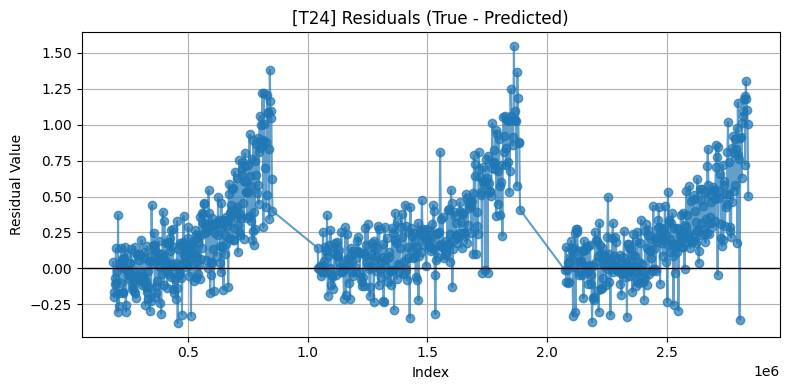

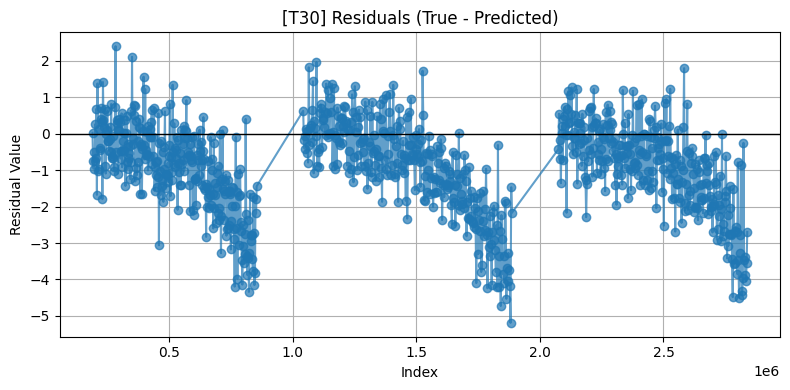

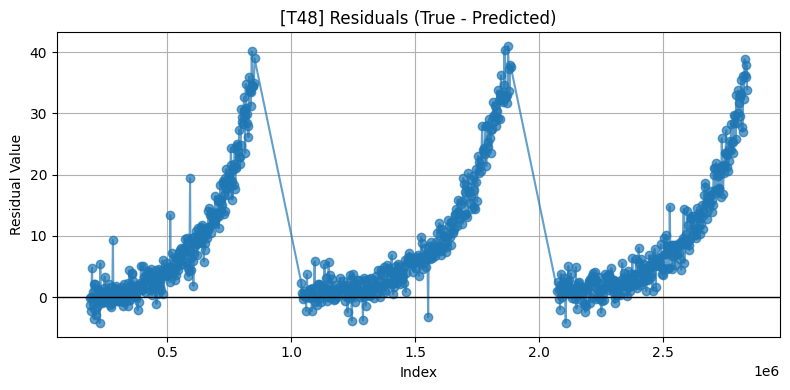

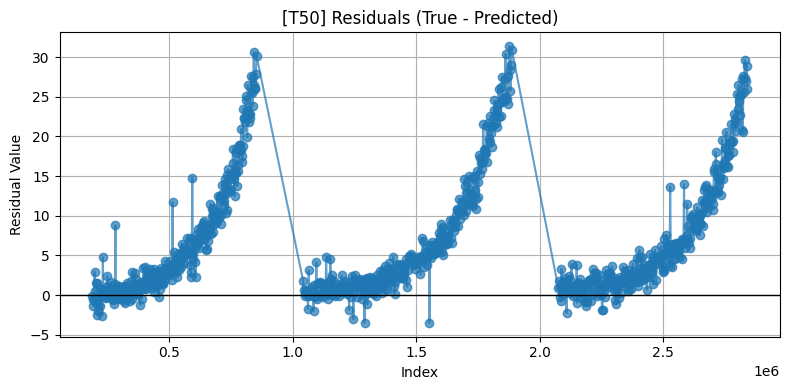

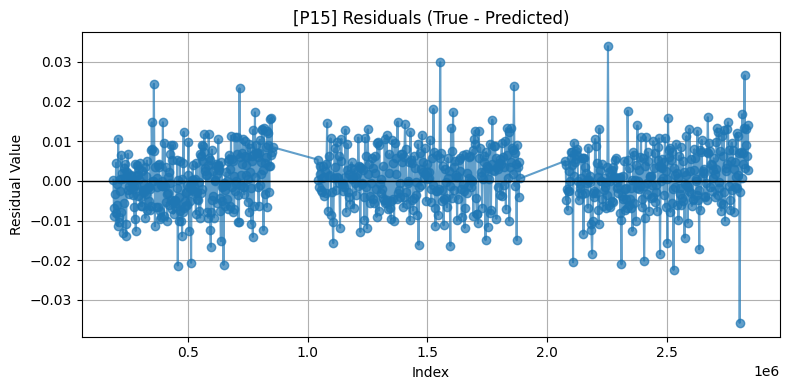

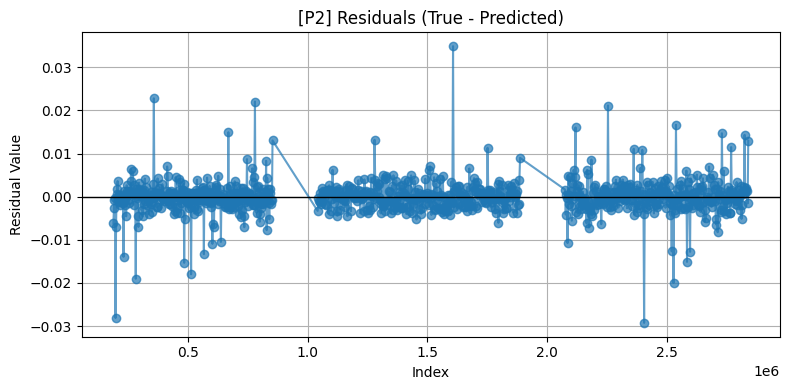

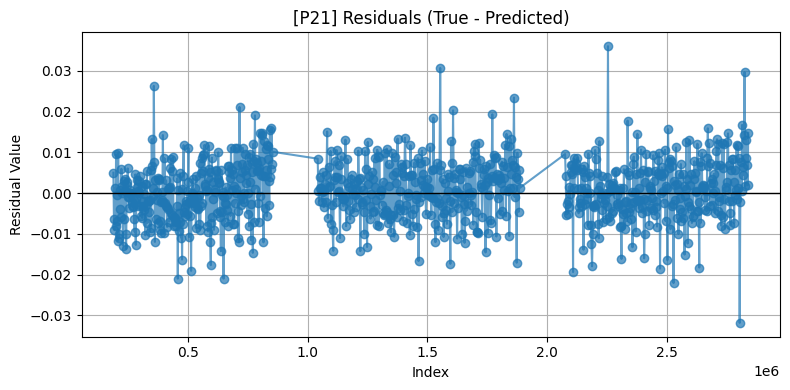

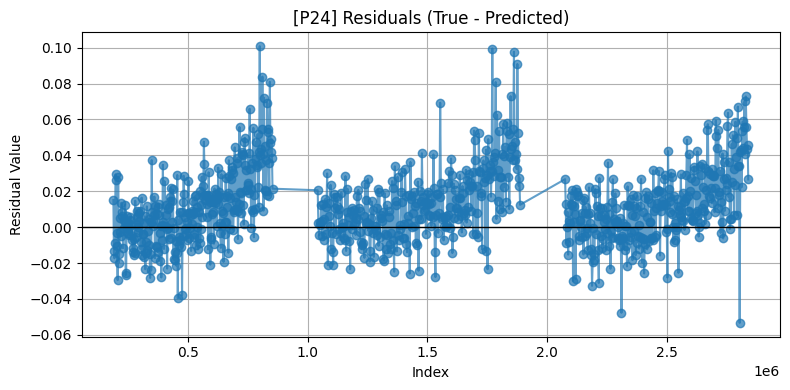

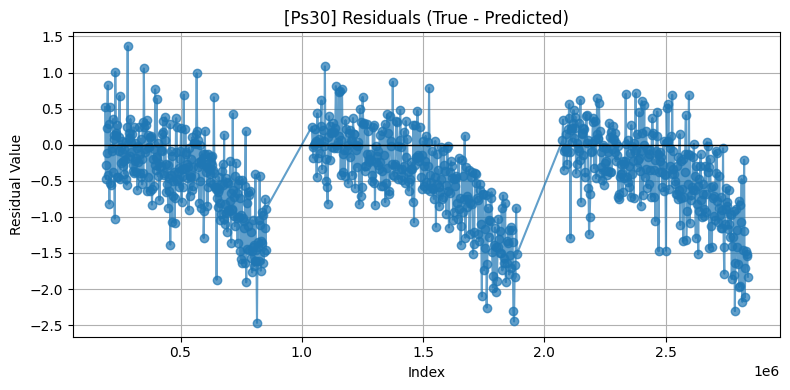

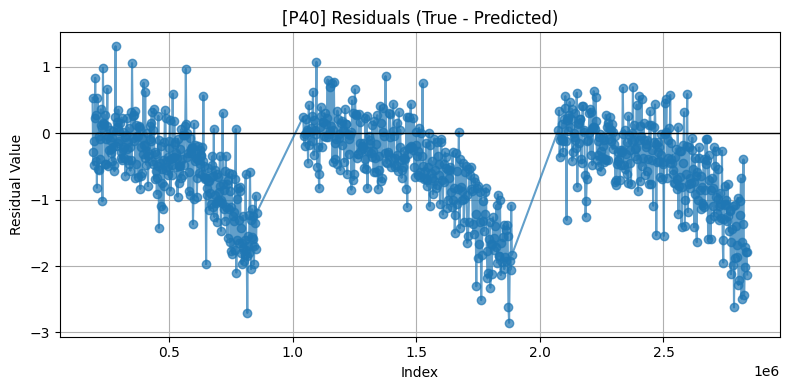

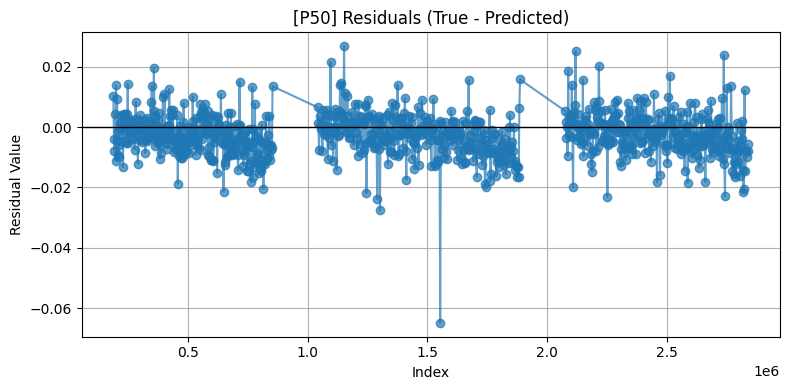

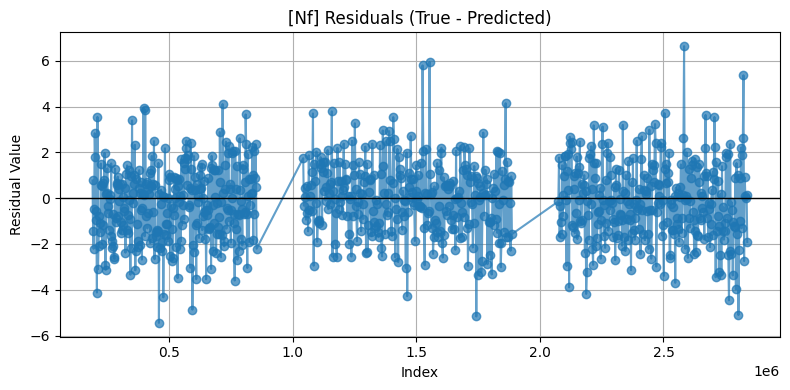

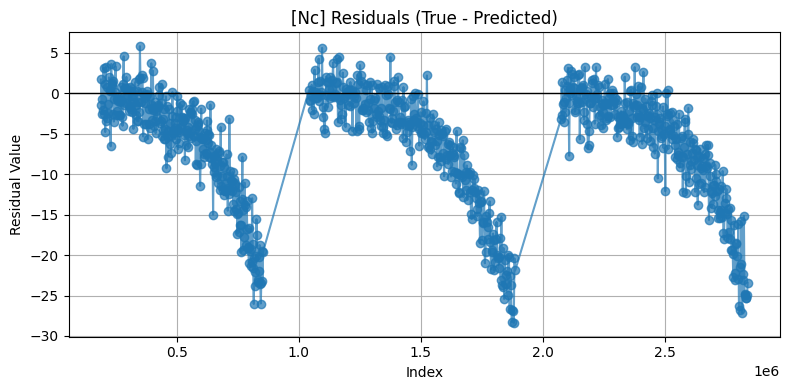

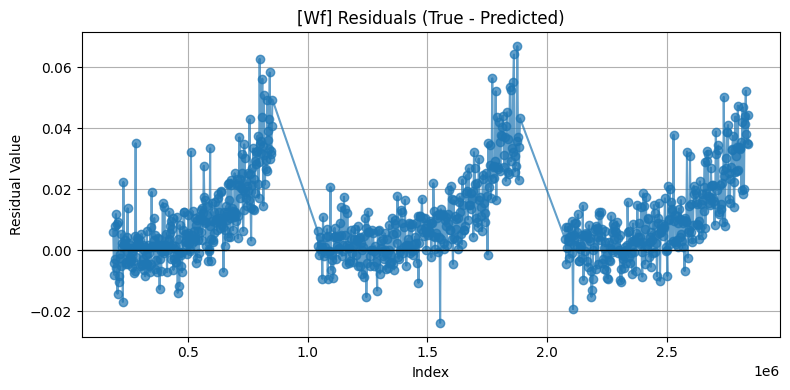

In [7]:
import gpytorch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

output_names = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24',
                'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']

# 0) 잔차 저장용
all_residuals = []
high_r2_list = []
total_all_idx = sampled_test_idx

sampled_idx = sampled_test_idx
# N_sel = min(N, len(total_all_idx))
# sampled_idx = np.random.choice(total_all_idx, size=N_sel, replace=False)
# sampled_idx.sort()
print(f"[INFO] common sampled_idx len = {len(sampled_idx)}")

# =========================================================
# 1) 다출력 GP 모델 정의
# =========================================================
num_tasks = Y.shape[1]   # 14

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # 각 task별 상수 평균 + multitask 구조
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        # 입력 커널(RBF) × task 간 공분산(coregionalization)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(),
            num_tasks=num_tasks,
            rank=2,   # task 공분산 rank (필요시 조정)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)       # (N, num_tasks)
        covar_x = self.covar_module(x)     # Multitask 커널
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# 학습 데이터
train_x = x_scaled.to(device)      # (N_dev, D)
train_y = y_scaled.to(device)      # (N_dev, 14)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks
).to(device)

model = MultitaskGPModel(train_x, train_y, likelihood).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# =========================================================
# 2) train (한 번만)
# =========================================================
model.train(); likelihood.train()
num_iters = 100
for i in range(num_iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # 필요하면 loss 출력
    # if (i+1) % 10 == 0:
    #     print(f"Iter {i+1}/{num_iters}, loss={loss.item():.4f}")

# =========================================================
# 3) TEST 전체에 대한 다출력 예측 + 지표
# =========================================================
model.eval(); likelihood.eval()

x_test_scaled = (x_test - x_mean) / x_std
x_test_scaled = x_test_scaled.to(device)

y_test_scaled = (y_test - y_mean) / y_std     # (N_test, 14)
y_test_scaled_t = y_test_scaled.to(device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(x_test_scaled))
    mean_all = preds.mean    # (N_test, 14)

# 출력별 지표 계산
for j, name in enumerate(output_names):
    y_true_j = y_test_scaled_t[:, j].cpu().numpy()
    y_pred_j = mean_all[:, j].cpu().numpy()

    mse  = mean_squared_error(y_true_j, y_pred_j)
    mae  = mean_absolute_error(y_true_j, y_pred_j)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_j, y_pred_j)
    high_r2_list.append({
        "name": name,
        "r2": r2,
    })

    print(f"\n=== [{j}] {name} ===")
    print(f"[Value]")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

# =========================================================
# 4) 공통 인덱스(sampled_idx)에서 잔차 (실제 - 예측) 저장
# =========================================================
# 4-1) 공통 인덱스의 입력
x_sel = torch.tensor(W_dev[sampled_idx], dtype=torch.float32, device=device)
x_sel_scaled = (x_sel - x_mean) / x_std

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_sel = likelihood(model(x_sel_scaled))
    mean_sel_all = preds_sel.mean          # (N_sel, 14)

# 4-2) 출력별 잔차 계산 (언스케일)
for j, name in enumerate(output_names):
    # 실제값 (원 스케일)
    y_true_unscaled = torch.tensor(
        X_s_dev[sampled_idx, j],
        dtype=torch.float32,
        device=device
    )

    # 예측값 (원 스케일로 되돌리기)
    y_pred_unscaled = mean_sel_all[:, j] * y_std[j] + y_mean[j]

    residual = (y_true_unscaled - y_pred_unscaled).detach().cpu().numpy()

    all_residuals.append({
        "name": name,
        "idx": sampled_idx.copy(),
        "residual": residual.copy(),
    })
    # print(f"[STORE] {name} residual saved. N={len(residual)}")
    plt.figure(figsize=(8,4))
    plt.plot(sampled_idx, residual, marker='o', linestyle='-', alpha=0.7)
    plt.axhline(0, color='black', linewidth=1)         # baseline
    plt.title(f"[{name}] Residuals (True - Predicted)")
    plt.xlabel("Index")
    plt.ylabel("Residual Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
print("len(all_residuals) =", len(all_residuals))

# 각 변수별 residual/idx 길이 확인
for i, d in enumerate(all_residuals):
    print(f"[{i:02d}] {d['name']}: len(idx)={len(d['idx'])}, len(residual)={len(d['residual'])}")

# (선택) 길이가 서로 다른지 요약
lens = [len(d["residual"]) for d in all_residuals]
print("unique residual lengths =", sorted(set(lens)))

len(all_residuals) = 14
[00] T24: len(idx)=900, len(residual)=900
[01] T30: len(idx)=900, len(residual)=900
[02] T48: len(idx)=900, len(residual)=900
[03] T50: len(idx)=900, len(residual)=900
[04] P15: len(idx)=900, len(residual)=900
[05] P2: len(idx)=900, len(residual)=900
[06] P21: len(idx)=900, len(residual)=900
[07] P24: len(idx)=900, len(residual)=900
[08] Ps30: len(idx)=900, len(residual)=900
[09] P40: len(idx)=900, len(residual)=900
[10] P50: len(idx)=900, len(residual)=900
[11] Nf: len(idx)=900, len(residual)=900
[12] Nc: len(idx)=900, len(residual)=900
[13] Wf: len(idx)=900, len(residual)=900
unique residual lengths = [900]


In [9]:
signal_names = []
residual_matrix = []

for r in all_residuals:
    signal_names.append(r["name"])
    residual_matrix.append(r["residual"])

# shape: (num_signals, num_samples)
residual_matrix = np.vstack(residual_matrix)

corr_matrix = np.corrcoef(residual_matrix)

distance_matrix = 1 - np.abs(corr_matrix)

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

D_condensed = squareform(distance_matrix, checks=False)
Z = linkage(D_condensed, method="average")

rho_th = 0.75
dist_th = 1 - rho_th

clusters = fcluster(Z, t=dist_th, criterion="distance")

hi_feature_idx = []

for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    hi_feature_idx.append(idx[0])   # 임의 선택 (첫 번째)

hi_var_names = [signal_names[i] for i in hi_feature_idx]
selected_residuals = residual_matrix[hi_feature_idx]
print(hi_var_names)

['P15', 'Nf', 'T24', 'T30', 'P50', 'P2']


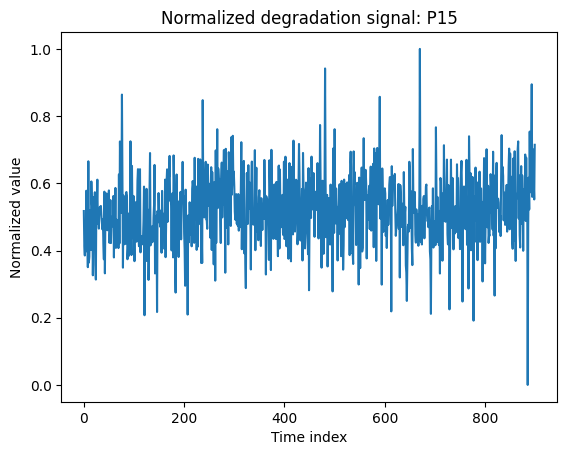

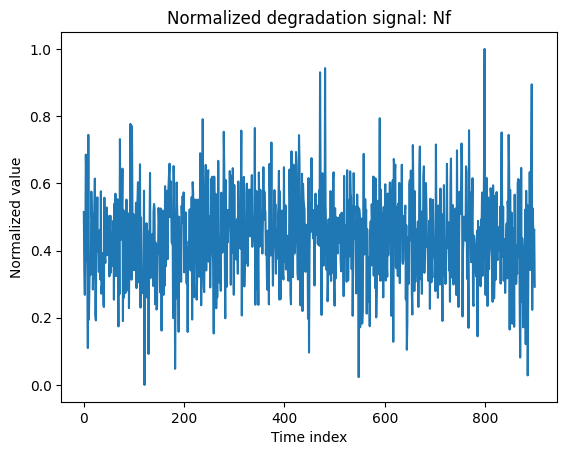

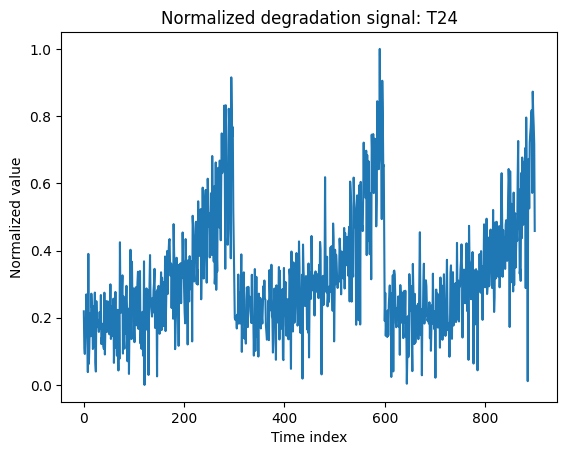

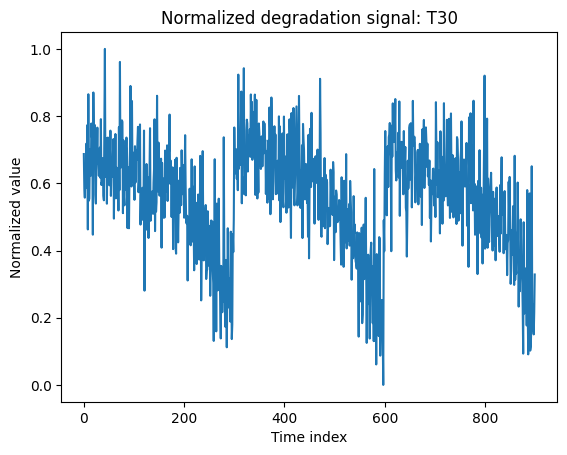

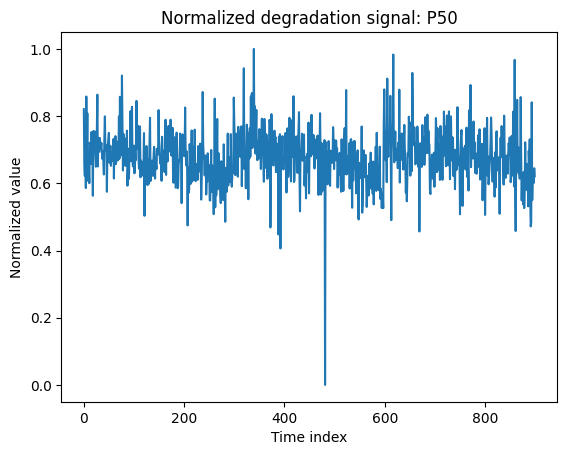

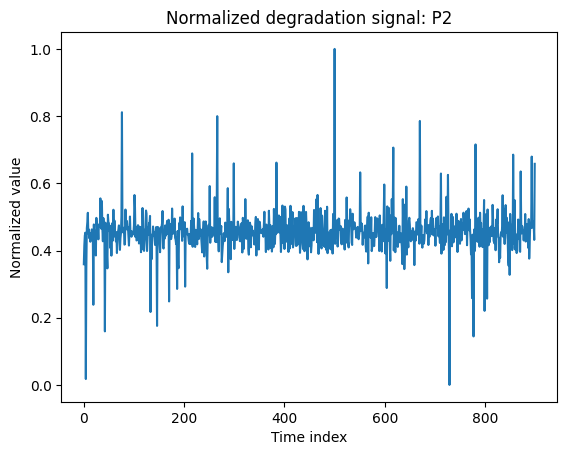

In [10]:
X = selected_residuals

X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)

X_norm = (X - X_min) / (X_max - X_min + 1e-8)

num_signals = X_norm.shape[0]
t = np.arange(X_norm.shape[1])

for i in range(num_signals):
    plt.figure()
    plt.plot(t, X_norm[i])
    plt.xlabel("Time index")
    plt.ylabel("Normalized value")
    plt.title(f"Normalized degradation signal: {hi_var_names[i]}")
    plt.show()


In [11]:
print(X_norm.shape)

(6, 900)


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Activation Functions
class TanhActivation:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output ** 2)

class LinearActivation:
    def forward(self, x):
        self.output = x
        return self.output
    
    def backward(self, grad_output):
        return grad_output

# Dense Layer
class DenseLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.grad_weights = None
        self.grad_bias = None
        self.input = None
    
    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = np.dot(grad_output, self.weights.T)
        return grad_input

# Neural Network Model
class NeuralDataFusionModel:
    def __init__(self, input_dim):
        self.layer1 = DenseLayer(input_dim, 4)
        self.activation1 = TanhActivation()
        self.layer2 = DenseLayer(4, 2)
        self.activation2 = TanhActivation()
        self.layer3 = DenseLayer(2, 1)
        self.activation3 = LinearActivation()
        
        self.parameters = [
            self.layer1.weights, self.layer1.bias,
            self.layer2.weights, self.layer2.bias,
            self.layer3.weights, self.layer3.bias
        ]
        self.gradients = []
    
    def forward(self, x):
        out = self.layer1.forward(x)
        out = self.activation1.forward(out)
        out = self.layer2.forward(out)
        out = self.activation2.forward(out)
        out = self.layer3.forward(out)
        out = self.activation3.forward(out)
        return out
    
    def backward(self, grad_output):
        grad = self.activation3.backward(grad_output)
        grad = self.layer3.backward(grad)
        grad = self.activation2.backward(grad)
        grad = self.layer2.backward(grad)
        grad = self.activation1.backward(grad)
        grad = self.layer1.backward(grad)
        
        self.gradients = [
            self.layer1.grad_weights, self.layer1.grad_bias,
            self.layer2.grad_weights, self.layer2.grad_bias,
            self.layer3.grad_weights, self.layer3.grad_bias
        ]
        return grad

# Delta function
def delta_function(x):
    return (x > 0).astype(float)

# Loss and Gradient Computation with DEBUG
def compute_loss_and_gradients(model, X_norm, K, lambda1=0.001, lambda2=0.001, 
                                lambda_init=10.0, init_threshold=0.5, step_gap=5, 
                                debug=False, epoch=0):
    """
    lambda_init: 초기 HI 제약 가중치
    init_threshold: 초기 HI 제약 임계값 (기본값: 0.5)
    step_gap: Term 3에서 비교할 시점 간격
    """
    num_features, total_samples = X_norm.shape
    N = total_samples // K
    
    loss_term0 = 0.0  # 초기 HI 제약
    loss_term1 = 0.0
    loss_term2 = 0.0
    loss_term3 = 0.0
    
    all_HI = []
    all_inputs = []
    
    if debug:
        print(f"\n{'='*80}")
        print(f"EPOCH {epoch} - LOSS COMPUTATION (step_gap: {step_gap}, init_threshold: {init_threshold})")
        print(f"{'='*80}")
    
    # Forward pass for all engines
    for n in range(N):
        start_idx = n * K
        end_idx = (n + 1) * K
        engine_data = X_norm[:, start_idx:end_idx].T
        all_inputs.append(engine_data)
        
        HI_n = model.forward(engine_data)
        all_HI.append(HI_n)
        
        if debug:
            print(f"\n[Engine {n+1}]")
            print(f"  HI range: [{HI_n.min():.6f}, {HI_n.max():.6f}]")
            print(f"  HI[0] (first): {HI_n[0, 0]:.6f}")
            print(f"  HI[{K-1}] (last, T_n): {HI_n[-1, 0]:.6f}")
        
        # Term 0: 초기 HI는 init_threshold 이하로
        h_n_T0 = HI_n[0, 0]
        if h_n_T0 > init_threshold:
            term0_contribution = (h_n_T0 - init_threshold) ** 2
        else:
            term0_contribution = 0.0
        loss_term0 += term0_contribution
        
        if debug:
            print(f"  Loss Term 0 contribution: {term0_contribution:.6f} (initial HI constraint <= {init_threshold})")
        
        # Term 1: 마지막 HI는 1에 가깝게
        h_n_Tn = HI_n[-1, 0]
        term1_contribution = (h_n_Tn - 1) ** 2
        loss_term1 += term1_contribution
        
        if debug:
            print(f"  Loss Term 1 contribution: {term1_contribution:.6f} (target: h_n(T_n)=1)")
        
        # Term 2: monotonicity
        T_n = K
        term2_contribution = 0.0
        monotonicity_violations = 0
        
        for t in range(1, T_n):
            d_nt = HI_n[t, 0] - HI_n[t-1, 0]
            exp_d = np.exp(d_nt)
            penalty = max(exp_d - 1, 0)
            term2_contribution += (1.0 / (T_n - 1)) * penalty
            
            if d_nt < 0:
                monotonicity_violations += 1
        
        loss_term2 += term2_contribution
        
        if debug:
            print(f"  Loss Term 2 contribution: {term2_contribution:.6f}")
            print(f"  Monotonicity violations: {monotonicity_violations}/{T_n-1}")
        
        # Term 3: convexity with step_gap
        term3_contribution = 0.0
        convexity_violations = 0
        
        for t in range(step_gap + 1, T_n):
            # 현재 기울기
            current_slope = HI_n[t, 0] - HI_n[t-1, 0]
            # step_gap 전 기울기
            past_slope = HI_n[t-step_gap, 0] - HI_n[t-step_gap-1, 0]
            
            diff = current_slope - past_slope
            exp_diff = np.exp(-diff)
            penalty = max(exp_diff - 1, 0)
            term3_contribution += (1.0 / (T_n - step_gap - 1)) * penalty
            
            if diff < 0:
                convexity_violations += 1
        
        loss_term3 += term3_contribution
        
        if debug:
            print(f"  Loss Term 3 contribution: {term3_contribution:.6f}")
            print(f"  Convexity violations: {convexity_violations}/{T_n-step_gap-1}")
            
            diffs = np.diff(HI_n.flatten())
            print(f"  Gradient (dHI/dt) stats:")
            print(f"    Mean: {diffs.mean():.6f}, Std: {diffs.std():.6f}")
    
    total_loss = lambda_init * loss_term0 + loss_term1 + lambda1 * loss_term2 + lambda2 * loss_term3
    
    if debug:
        print(f"\n{'='*80}")
        print(f"LOSS BREAKDOWN:")
        print(f"  Term 0 (Initial HI <= {init_threshold}): {loss_term0:.6f} (×{lambda_init})")
        print(f"  Term 1 (Target HI=1): {loss_term1:.6f} (×1.0)")
        print(f"  Term 2 (Monotonicity): {loss_term2:.6f} (×{lambda1})")
        print(f"  Term 3 (Convexity): {loss_term3:.6f} (×{lambda2})")
        print(f"  Total Loss: {total_loss:.6f}")
        print(f"{'='*80}")
    
    # Compute gradients
    total_grad_output = []
    
    for n in range(N):
        HI_n = all_HI[n]
        T_n = K
        grad_h = np.zeros_like(HI_n)
        
        # Gradient from term 0 (initial HI constraint)
        h_n_T0 = HI_n[0, 0]
        if h_n_T0 > init_threshold:
            grad_h[0, 0] += 2 * lambda_init * (h_n_T0 - init_threshold)
        
        # Gradient from term 1 (final HI)
        h_n_Tn = HI_n[-1, 0]
        grad_h[-1, 0] += 2 * (h_n_Tn - 1)
        
        # Gradient from term 2 (monotonicity)
        for t in range(1, T_n):
            d_nt = HI_n[t, 0] - HI_n[t-1, 0]
            exp_d = np.exp(d_nt)
            delta_exp = delta_function(exp_d - 1)
            grad_d_nt = (lambda1 / (T_n - 1)) * delta_exp * exp_d
            grad_h[t, 0] += grad_d_nt
            grad_h[t-1, 0] -= grad_d_nt
        
        # Gradient from term 3 (convexity with step_gap)
        for t in range(step_gap + 1, T_n):
            current_slope = HI_n[t, 0] - HI_n[t-1, 0]
            past_slope = HI_n[t-step_gap, 0] - HI_n[t-step_gap-1, 0]
            
            diff = current_slope - past_slope
            exp_diff = np.exp(-diff)
            delta_exp_diff = delta_function(exp_diff - 1)
            
            grad_diff = (lambda2 / (T_n - step_gap - 1)) * delta_exp_diff * exp_diff * (-1)
            
            grad_h[t, 0] += grad_diff * 1
            grad_h[t-1, 0] += grad_diff * (-1)
            grad_h[t-step_gap, 0] += grad_diff * (-1)
            grad_h[t-step_gap-1, 0] += grad_diff * 1
        
        total_grad_output.append(grad_h)
    
    # Backpropagation
    for n in range(N):
        engine_data = all_inputs[n]
        grad_output = total_grad_output[n]
        _ = model.forward(engine_data)
        model.backward(grad_output)
        
        if n == 0:
            accumulated_grads = [g.copy() for g in model.gradients]
        else:
            for i in range(len(accumulated_grads)):
                accumulated_grads[i] += model.gradients[i]
    
    for i in range(len(accumulated_grads)):
        accumulated_grads[i] /= N
    
    if debug:
        print(f"\nPARAMETER GRADIENTS (averaged over {N} engines):")
        grad_names = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
        for i, (name, grad) in enumerate(zip(grad_names, accumulated_grads)):
            print(f"  {name}: mean={grad.mean():.8f}, std={grad.std():.8f}, max_abs={np.abs(grad).max():.8f}")
    
    model.gradients = accumulated_grads
    return total_loss

# Adam Optimizer
class AdamOptimizer:
    def __init__(self, parameters, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p) for p in parameters]
        self.v = [np.zeros_like(p) for p in parameters]
        self.t = 0
    
    def step(self, parameters, gradients, debug=False):
        self.t += 1
        
        if debug:
            print(f"\nADAM OPTIMIZER UPDATE (step {self.t}):")
        
        for i in range(len(parameters)):
            g = gradients[i]
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            update = self.alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)
            parameters[i] -= update
            
            if debug and i < 2:  # Only show first 2 parameters
                param_names = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
                print(f"  {param_names[i]}: update_mean={update.mean():.8f}, update_max_abs={np.abs(update).max():.8f}")

# Training Function with DEBUG
def train_model(X_norm, K, epochs=1000, lambda1=0.001, lambda2=0.001, 
                lambda_init=10.0, init_threshold=0.5, step_gap=5, 
                alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                verbose=True, print_every=100, debug_epochs=None):
    """
    init_threshold: 초기 HI 제약 임계값 (기본값: 0.5)
    """
    num_features = X_norm.shape[0]
    model = NeuralDataFusionModel(input_dim=num_features)
    optimizer = AdamOptimizer(model.parameters, alpha, beta1, beta2, epsilon)
    loss_history = []
    
    if debug_epochs is None:
        debug_epochs = [epochs * i // 10 for i in range(1, 11)]
    
    print(f"Debug epochs: {debug_epochs}")
    print(f"Initial HI threshold: {init_threshold}")
    
    for epoch in range(epochs):
        debug = (epoch + 1) in debug_epochs
        
        loss = compute_loss_and_gradients(
            model, X_norm, K, lambda1, lambda2, lambda_init, init_threshold, 
            step_gap, debug=debug, epoch=epoch+1
        )
        loss_history.append(loss)
        optimizer.step(model.parameters, model.gradients, debug=debug)
        
        if verbose and (epoch + 1) % print_every == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")
    
    return model, loss_history

# Prediction Function
def predict(model, X_norm, K):
    num_features, total_samples = X_norm.shape
    N = total_samples // K
    predictions = []
    
    for n in range(N):
        start_idx = n * K
        end_idx = (n + 1) * K
        engine_data = X_norm[:, start_idx:end_idx].T
        HI_n = model.forward(engine_data)
        predictions.append(HI_n.flatten())
    
    return predictions

# Loss Function Mathematical Formulas

## Total Loss Function

$$L_{total} = \lambda_{init} \cdot L_0 + L_1 + \lambda_1 \cdot L_2 + \lambda_2 \cdot L_3$$

---

## Term 0: Initial HI Constraint

$$L_0 = \sum_{n=1}^{N} \max(h_n(0) - \theta_{init}, 0)^2$$

**Gradient:**

$$\frac{\partial L_0}{\partial h_n(0)} = \begin{cases} 
2\lambda_{init}(h_n(0) - \theta_{init}) & \text{if } h_n(0) > \theta_{init} \\
0 & \text{otherwise}
\end{cases}$$

---

## Term 1: Target HI Constraint

$$L_1 = \sum_{n=1}^{N} (h_n(T_n) - 1)^2$$

**Gradient:**

$$\frac{\partial L_1}{\partial h_n(T_n)} = 2(h_n(T_n) - 1)$$

---

In [13]:
# 모델 학습
epochs_total = 1000
debug_epochs = [epochs_total * i // 10 for i in range(1, 11)]

print(f"Debug will be shown at epochs: {debug_epochs}")

# 예시 1: init_threshold = 0.3
model, loss_history = train_model(
    X_norm, 
    K, 
    epochs=1000,
    lambda1=3.5,
    lambda2=1.0,
    lambda_init=10.0,
    init_threshold=0.2,  # 초기 HI를 0.3 이하로 제약
    step_gap=5,
    alpha=0.001,
    verbose=False,
    print_every=100
)

Debug will be shown at epochs: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Debug epochs: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Initial HI threshold: 0.2

EPOCH 100 - LOSS COMPUTATION (step_gap: 5, init_threshold: 0.2)

[Engine 1]
  HI range: [0.186798, 0.230089]
  HI[0] (first): 0.215551
  HI[299] (last, T_n): 0.218326
  Loss Term 0 contribution: 0.000242 (initial HI constraint <= 0.2)
  Loss Term 1 contribution: 0.611014 (target: h_n(T_n)=1)
  Loss Term 2 contribution: 0.003879
  Monotonicity violations: 150/299
  Loss Term 3 contribution: 0.005498
  Convexity violations: 144/294
  Gradient (dHI/dt) stats:
    Mean: 0.000009, Std: 0.009689

[Engine 2]
  HI range: [0.190082, 0.230606]
  HI[0] (first): 0.219610
  HI[299] (last, T_n): 0.215604
  Loss Term 0 contribution: 0.000385 (initial HI constraint <= 0.2)
  Loss Term 1 contribution: 0.615277 (target: h_n(T_n)=1)
  Loss Term 2 contribution: 0.003784
  Monotonicity violations: 162/299
  Loss Term 3 contribution: 

In [14]:
 # 예측
predictions = predict(model, X_norm, K)

print(f"\nFinal Loss: {loss_history[-1]:.6f}")
for i, pred in enumerate(predictions):
    print(f"Engine {i+1}: Final HI = {pred[-1]:.6f}")


Final Loss: 0.736351
Engine 1: Final HI = 0.778537
Engine 2: Final HI = 0.842975
Engine 3: Final HI = 0.823938


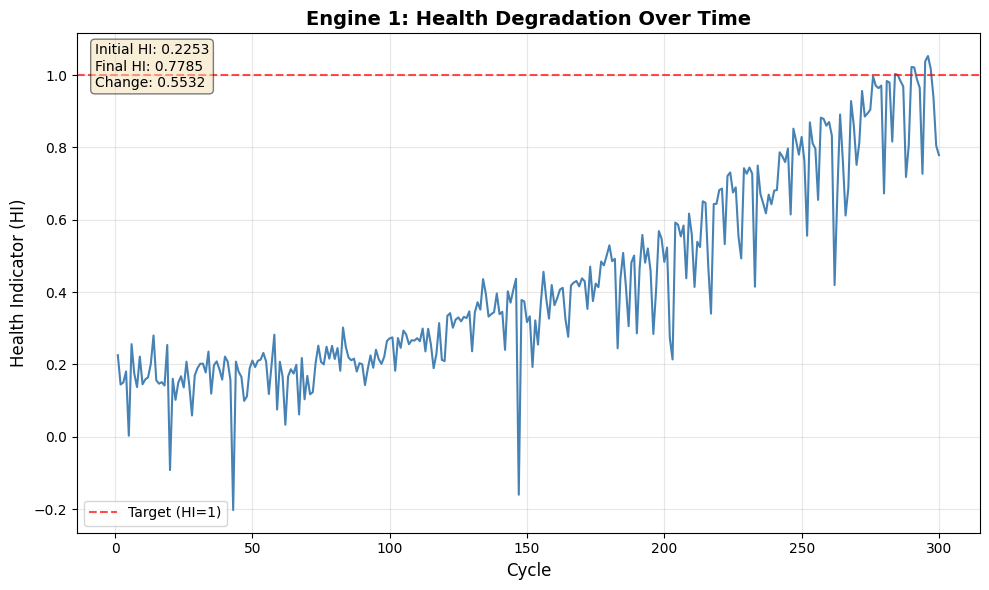

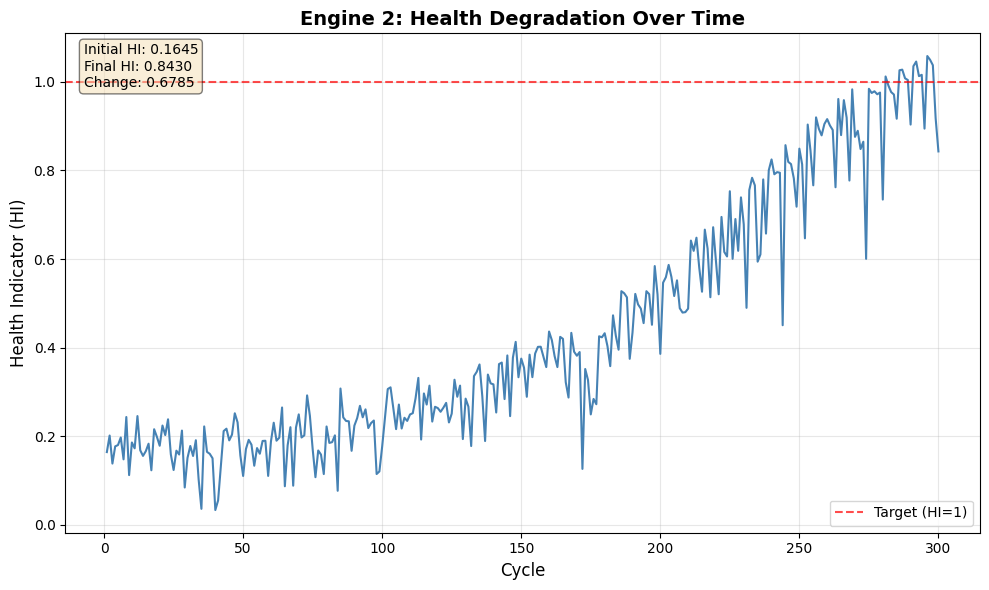

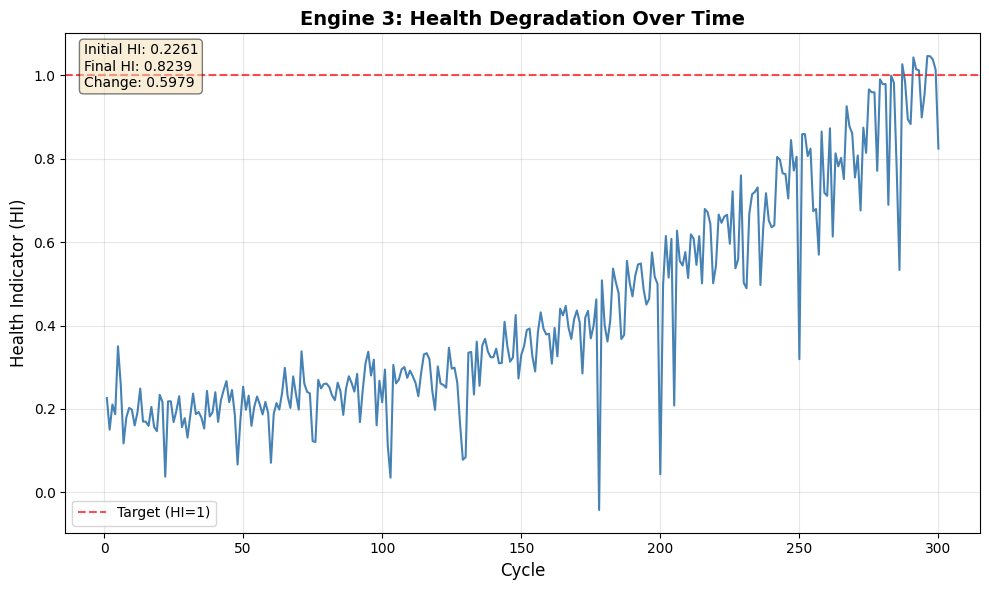

In [15]:
# 각 엔진별로 개별 그래프 생성

for i, pred in enumerate(predictions):
    plt.figure(figsize=(10, 6))
    cycles = np.arange(1, len(pred) + 1)
    
    plt.plot(cycles, pred, linewidth=1.5, color='steelblue')
    plt.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='Target (HI=1)', alpha=0.7)
    
    plt.xlabel('Cycle', fontsize=12)
    plt.ylabel('Health Indicator (HI)', fontsize=12)
    plt.title(f'Engine {i+1}: Health Degradation Over Time', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 통계 정보 추가
    plt.text(0.02, 0.98, 
             f'Initial HI: {pred[0]:.4f}\nFinal HI: {pred[-1]:.4f}\nChange: {pred[-1]-pred[0]:.4f}', 
             transform=plt.gca().transAxes, fontsize=10, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

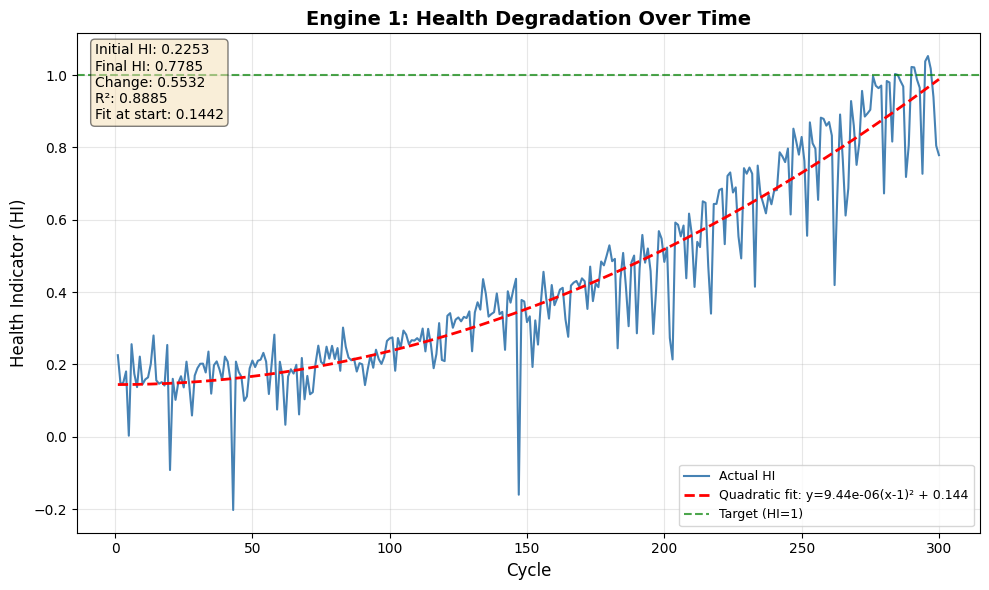

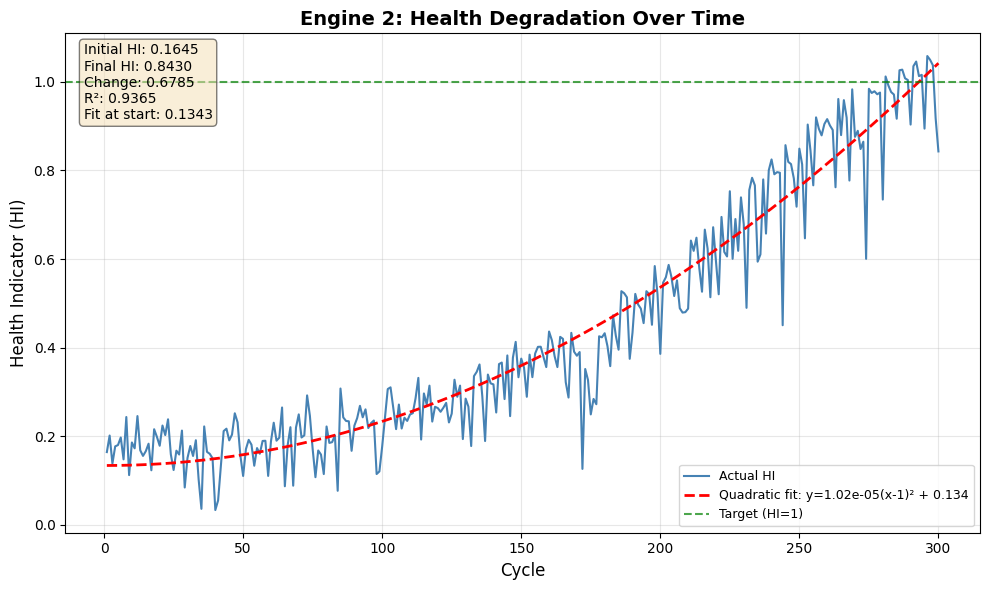

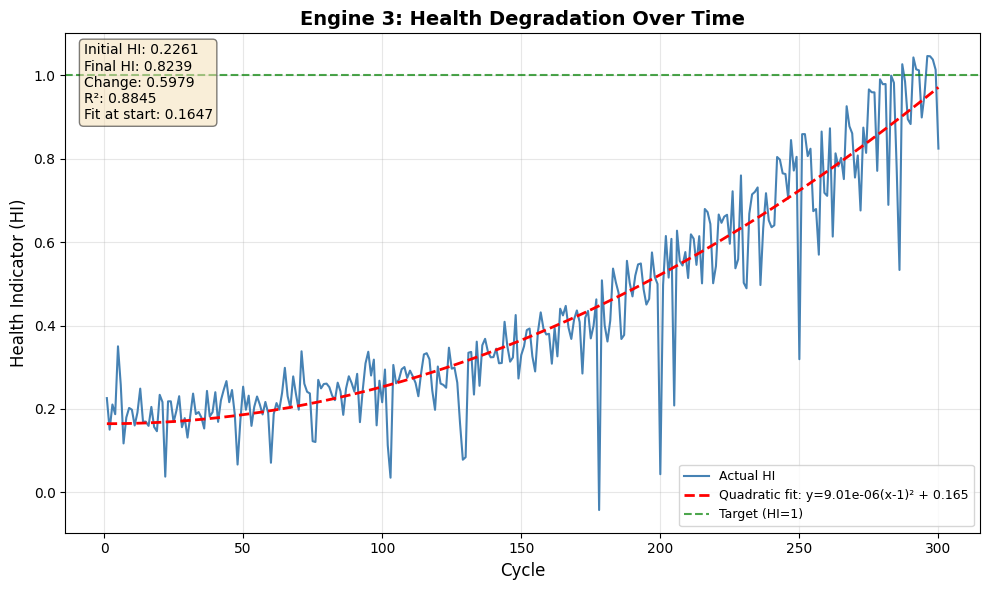

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# 이차함수 정의 (시작점 고정)
def quadratic_fixed_start(x, a, b):
    """
    시작점(x=1)이 최소값이 되도록 고정
    y = a(x-1)² + c
    여기서 c는 실제 시작점 값으로 고정
    """
    return a * (x - 1)**2 + b

# 각 엔진별로 개별 그래프 생성 (이차함수 추세선 포함)
for i, pred in enumerate(predictions):
    plt.figure(figsize=(10, 6))
    cycles = np.arange(1, len(pred) + 1)
    
    # 원본 데이터
    plt.plot(cycles, pred, linewidth=1.5, color='steelblue', label='Actual HI')
    
    # 이차함수 피팅 (시작점 고정)
    try:
        # 시작점 값
        start_value = pred[0]
        
        # curve_fit을 사용하여 a, b 파라미터 추정
        # 초기 추정값 설정
        initial_guess = [0.001, start_value]
        popt, _ = curve_fit(quadratic_fixed_start, cycles, pred, p0=initial_guess)
        
        # 피팅된 이차함수 값 계산
        fitted_values = quadratic_fixed_start(cycles, *popt)
        
        # 추세선 그리기
        plt.plot(cycles, fitted_values, linewidth=2, color='red', 
                linestyle='--', label=f'Quadratic fit: y={popt[0]:.2e}(x-1)² + {popt[1]:.3f}')
        
        # R² 계산
        residuals = pred - fitted_values
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((pred - np.mean(pred))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # 검증: 시작점이 실제로 최소값인지 확인
        fit_start = quadratic_fixed_start(1, *popt)
        
    except Exception as e:
        print(f"Engine {i+1}: 이차함수 피팅 실패 - {e}")
        r_squared = None
        fit_start = None
    
    plt.axhline(y=1.0, color='green', linestyle='--', linewidth=1.5, 
               label='Target (HI=1)', alpha=0.7)
    
    plt.xlabel('Cycle', fontsize=12)
    plt.ylabel('Health Indicator (HI)', fontsize=12)
    plt.title(f'Engine {i+1}: Health Degradation Over Time', fontsize=14, fontweight='bold')
    plt.legend(fontsize=9, loc='best')
    plt.grid(True, alpha=0.3)
    
    # 통계 정보 추가
    info_text = f'Initial HI: {pred[0]:.4f}\nFinal HI: {pred[-1]:.4f}\nChange: {pred[-1]-pred[0]:.4f}'
    if r_squared is not None:
        info_text += f'\nR²: {r_squared:.4f}'
    if fit_start is not None:
        info_text += f'\nFit at start: {fit_start:.4f}'
    
    plt.text(0.02, 0.98, info_text,
             transform=plt.gca().transAxes, fontsize=10, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

Engine 1:
  학습 데이터: 210 cycles (70%)
  학습된 함수: y = 8.53e-06(x-1)² + 0.1539
  R²: 0.6735
  현재 HI (70% 지점): 0.5594
  예측 EOL: 316.0 cycles
  잔여 수명 (RUL): 106.0 cycles
  실제 EOL: 300 cycles
  예측 오차: +16.0 cycles

Engine 2:
  학습 데이터: 210 cycles (70%)
  학습된 함수: y = 8.31e-06(x-1)² + 0.1543
  R²: 0.7907
  현재 HI (70% 지점): 0.4882
  예측 EOL: 319.9 cycles
  잔여 수명 (RUL): 109.9 cycles
  실제 EOL: 300 cycles
  예측 오차: +19.9 cycles

Engine 3:
  학습 데이터: 210 cycles (70%)
  학습된 함수: y = 7.48e-06(x-1)² + 0.1823
  R²: 0.6284
  현재 HI (70% 지점): 0.5138
  예측 EOL: 331.7 cycles
  잔여 수명 (RUL): 121.7 cycles
  실제 EOL: 300 cycles
  예측 오차: +31.7 cycles



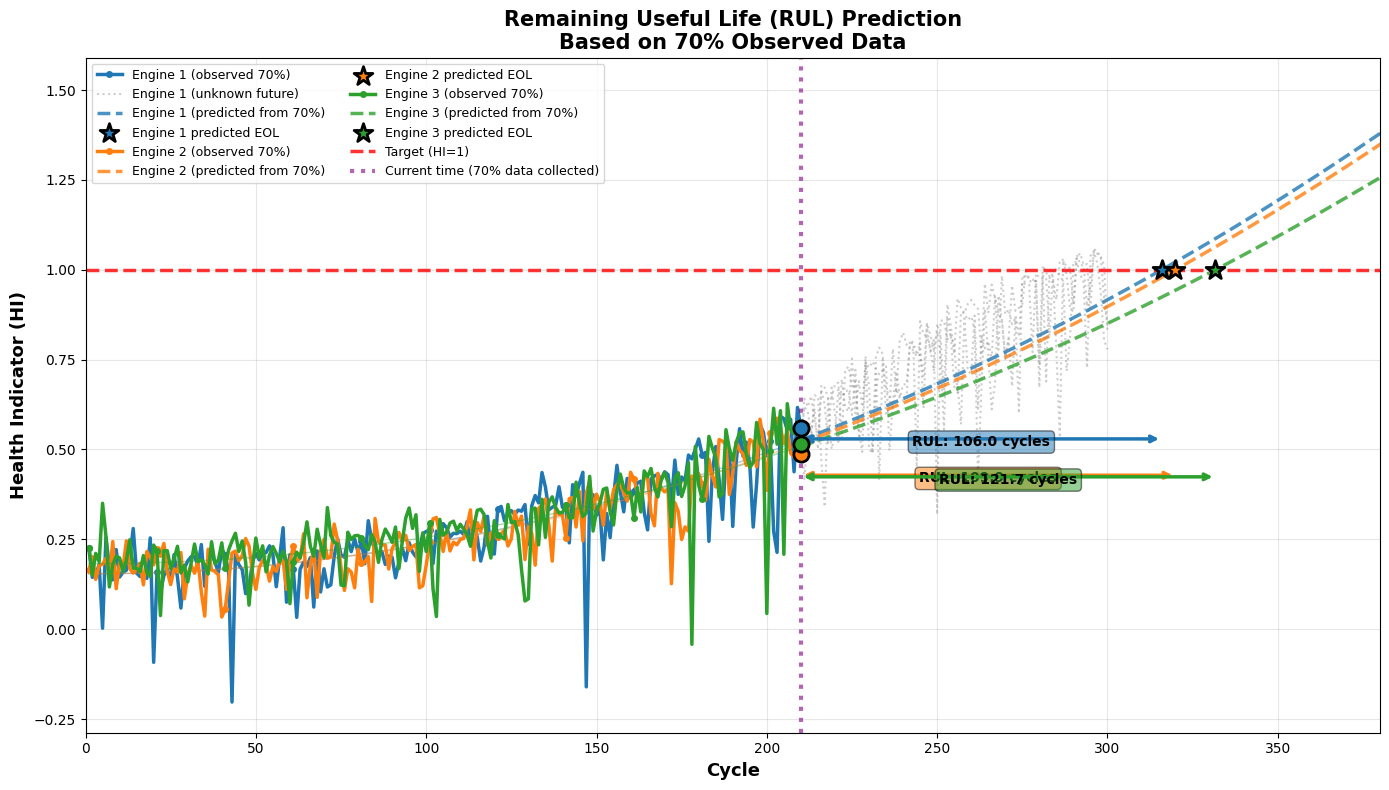


REMAINING USEFUL LIFE (RUL) PREDICTION SUMMARY
Training data: First 70% of observed cycles
Engine   Training     Current HI   Pred EOL     RUL        Actual EOL   Error      R²      
----------------------------------------------------------------------------------------------------
1        210/300      0.5594       316.0        106.0      300          16.0       0.6735  
2        210/300      0.4882       319.9        109.9      300          19.9       0.7907  
3        210/300      0.5138       331.7        121.7      300          31.7       0.6284  

Average RUL: 112.5 cycles
Average prediction error: 22.5 cycles
Average R²: 0.6975

Learned quadratic functions (from 70% data):
  Engine 1: y = 8.53e-06(x-1)² + 0.1539
  Engine 2: y = 8.31e-06(x-1)² + 0.1543
  Engine 3: y = 7.48e-06(x-1)² + 0.1823


In [17]:
import numpy as np
from scipy.optimize import curve_fit

# 이차함수 정의 (시작점 고정)
def quadratic_fixed_start(x, a, b):
    return a * (x - 1)**2 + b

# 통합 그래프
plt.figure(figsize=(14, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
results = []

# 데이터 수집 비율 설정
data_ratio = 0.7

for i, pred in enumerate(predictions):
    total_cycles = len(pred)
    cycles = np.arange(1, total_cycles + 1)
    
    # 70% 지점까지만 사용 (학습 데이터)
    split_point = int(total_cycles * data_ratio)
    cycles_train = cycles[:split_point]
    pred_train = pred[:split_point]
    
    # 실제 관측된 데이터 (70%까지)
    plt.plot(cycles_train, pred_train, linewidth=2.5, color=colors[i], 
             label=f'Engine {i+1} (observed {int(data_ratio*100)}%)', 
             marker='o', markersize=4, markevery=20)
    
    # 나머지 실제 데이터 (30% - 회색 점선으로 표시, 아직 모르는 미래)
    plt.plot(cycles[split_point-1:], pred[split_point-1:], linewidth=1.5, 
             color='gray', alpha=0.4, linestyle=':', 
             label=f'Engine {i+1} (unknown future)' if i == 0 else '')
    
    # 70% 데이터로 이차함수 피팅
    try:
        start_value = pred_train[0]
        initial_guess = [0.001, start_value]
        popt, pcov = curve_fit(quadratic_fixed_start, cycles_train, pred_train, 
                               p0=initial_guess)
        
        # 예측: 학습한 함수로 전체 구간 + 미래 예측
        cycles_predict = np.arange(1, total_cycles + 100)
        predicted_hi = quadratic_fixed_start(cycles_predict, *popt)
        
        # 예측 곡선 그리기 (70% 이후부터 표시)
        plt.plot(cycles_predict[split_point-1:], predicted_hi[split_point-1:], 
                linewidth=2.5, color=colors[i], linestyle='--', alpha=0.8,
                label=f'Engine {i+1} (predicted from 70%)')
        
        # 학습 구간도 표시 (얼마나 잘 피팅되었는지 확인)
        plt.plot(cycles_train, quadratic_fixed_start(cycles_train, *popt), 
                linewidth=1, color=colors[i], linestyle='-', alpha=0.4)
        
        # R² 계산 (학습 데이터에 대해)
        residuals = pred_train - quadratic_fixed_start(cycles_train, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((pred_train - np.mean(pred_train))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # HI = 1에 도달하는 사이클 예측
        if popt[0] > 0 and (1 - popt[1]) / popt[0] >= 0:
            cycle_at_hi_1 = 1 + np.sqrt((1 - popt[1]) / popt[0])
            
            # 현재 시점 (70% 지점)
            current_cycle = split_point
            current_hi = pred_train[-1]
            
            # 잔여 수명 (RUL)
            rul = cycle_at_hi_1 - current_cycle
            
            # 예측 도달 지점 표시
            plt.scatter(cycle_at_hi_1, 1.0, s=200, color=colors[i], 
                       marker='*', edgecolors='black', linewidth=2, zorder=5,
                       label=f'Engine {i+1} predicted EOL')
            
            # 현재 위치 표시
            plt.scatter(current_cycle, current_hi, s=120, color=colors[i], 
                       marker='o', edgecolors='black', linewidth=2, zorder=5)
            
            # 잔여 수명 화살표
            arrow_y = current_hi - 0.03 * (i + 1)  # 엔진별로 높이 조정
            plt.annotate('', xy=(cycle_at_hi_1, arrow_y), 
                        xytext=(current_cycle, arrow_y),
                        arrowprops=dict(arrowstyle='<->', color=colors[i], lw=2.5))
            
            plt.text((current_cycle + cycle_at_hi_1) / 2, arrow_y - 0.02, 
                    f'RUL: {rul:.1f} cycles', fontsize=10, ha='center', 
                    bbox=dict(boxstyle='round', facecolor=colors[i], alpha=0.5),
                    fontweight='bold')
            
            # 실제 EOL과 비교
            actual_eol = total_cycles
            prediction_error = cycle_at_hi_1 - actual_eol
            
            results.append({
                'engine': i+1,
                'training_data': f'{split_point}/{total_cycles}',
                'current_cycle': current_cycle,
                'current_hi': current_hi,
                'predicted_eol': cycle_at_hi_1,
                'rul': rul,
                'actual_eol': actual_eol,
                'error': abs(prediction_error),
                'r_squared': r_squared,
                'equation': f'y = {popt[0]:.2e}(x-1)² + {popt[1]:.4f}'
            })
            
            print(f"Engine {i+1}:")
            print(f"  학습 데이터: {split_point} cycles (70%)")
            print(f"  학습된 함수: y = {popt[0]:.2e}(x-1)² + {popt[1]:.4f}")
            print(f"  R²: {r_squared:.4f}")
            print(f"  현재 HI (70% 지점): {current_hi:.4f}")
            print(f"  예측 EOL: {cycle_at_hi_1:.1f} cycles")
            print(f"  잔여 수명 (RUL): {rul:.1f} cycles")
            print(f"  실제 EOL: {actual_eol} cycles")
            print(f"  예측 오차: {prediction_error:+.1f} cycles\n")
            
    except Exception as e:
        print(f"Engine {i+1}: 피팅 실패 - {e}")

# 기준선들
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2.5, 
           label='Target (HI=1)', alpha=0.8)
plt.axvline(x=split_point, color='purple', linestyle=':', linewidth=3, 
           alpha=0.6, label=f'Current time ({int(data_ratio*100)}% data collected)')

plt.xlabel('Cycle', fontsize=13, fontweight='bold')
plt.ylabel('Health Indicator (HI)', fontsize=13, fontweight='bold')
plt.title(f'Remaining Useful Life (RUL) Prediction\nBased on {int(data_ratio*100)}% Observed Data', 
         fontsize=15, fontweight='bold')
plt.legend(fontsize=9, loc='upper left', ncol=2)
plt.grid(True, alpha=0.3)
plt.xlim([0, max([len(p) for p in predictions]) + 80])

plt.tight_layout()
plt.show()

# 결과 테이블
print(f"\n{'='*100}")
print(f"REMAINING USEFUL LIFE (RUL) PREDICTION SUMMARY")
print(f"Training data: First {int(data_ratio*100)}% of observed cycles")
print(f"{'='*100}")
print(f"{'Engine':<8} {'Training':<12} {'Current HI':<12} {'Pred EOL':<12} {'RUL':<10} {'Actual EOL':<12} {'Error':<10} {'R²':<8}")
print(f"{'-'*100}")
for r in results:
    print(f"{r['engine']:<8} {r['training_data']:<12} {r['current_hi']:<12.4f} "
          f"{r['predicted_eol']:<12.1f} {r['rul']:<10.1f} {r['actual_eol']:<12} "
          f"{r['error']:<10.1f} {r['r_squared']:<8.4f}")
print(f"{'='*100}")

if results:
    avg_rul = np.mean([r['rul'] for r in results])
    avg_error = np.mean([r['error'] for r in results])
    avg_r2 = np.mean([r['r_squared'] for r in results])
    
    print(f"\nAverage RUL: {avg_rul:.1f} cycles")
    print(f"Average prediction error: {avg_error:.1f} cycles")
    print(f"Average R²: {avg_r2:.4f}")
    print(f"{'='*100}\n")
    
    # 각 엔진의 학습된 함수 출력
    print("Learned quadratic functions (from 70% data):")
    for r in results:
        print(f"  Engine {r['engine']}: {r['equation']}")